In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='white', 
        font='sans-serif', font_scale=1., 
        rc={'figure.figsize':(8,5)})

## Read data

In [7]:
train_070 = pd.read_csv(os.path.join("..", "database_split", "train_0-70.csv"))
val_070 = pd.read_csv(os.path.join("..", "database_split", "val_0-70.csv"))
test_070 = pd.read_csv(os.path.join("..", "database_split", "test_0-70.csv"))

train_70100 = pd.read_csv(os.path.join("..", "database_split", "train_70-100.csv"))
val_70100 = pd.read_csv(os.path.join("..", "database_split", "val_70-100.csv"))
test_70100 = pd.read_csv(os.path.join("..", "database_split", "test_70-100.csv"))

In [8]:
val_070['images'] = 'Validation'
val_070['split'] = "20-70 years"

val_70100['images'] = 'Validation'
val_70100['split'] = ">70 years"
val = pd.concat([val_070, val_70100]).reset_index(drop=True)

test_070['images'] = 'Test'
test_070['split'] = "20-70 years"

test_70100['images'] = 'Test'
test_70100['split'] = ">70 years"
test = pd.concat([test_070, test_70100]).reset_index(drop=True)

val_test = pd.concat([val, test])

/home/kpoloni/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 576x360 with 0 Axes>

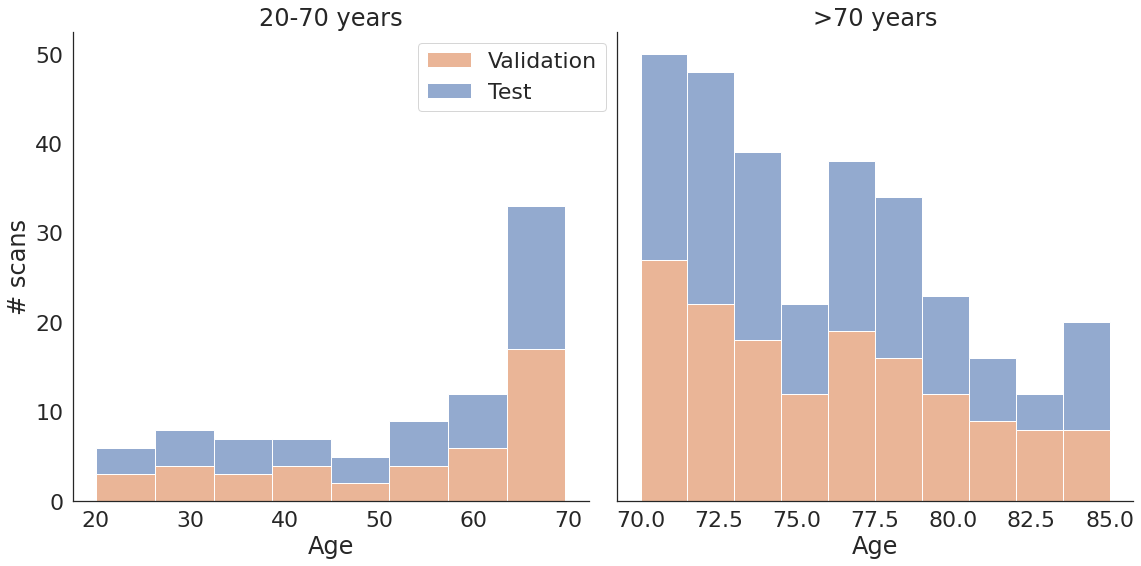

In [9]:
sns.set(context='notebook', style='white', 
        font='sans-serif', font_scale=2., 
        rc={'figure.figsize':(8,5)})



fig = plt.figure()
g = sns.FacetGrid(val_test, col="split", sharex=False,
                  height=5, size=8,
                #   col_order=["Raw dataset", "Data Augmented dataset"],
                  palette=sns.color_palette('Set2')
                  )
g.map_dataframe(sns.histplot, x="Age", alpha=.6, hue='images',
                hue_order=['Validation', 'Test'],
                multiple='stack',
                # common_bins=True, bins=21,
                label='Data'
                ) 
g.set_xlabels("Age")
g.set_ylabels("# scans")
g.set_titles("{col_name}")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Validation', 'Test']
order = [0, 1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0, 1))
plt.savefig('Val_test_distribution_070.pdf', bbox_inches='tight', dpi=300)


In [10]:
# Unique train images
unique_070 = train_070.drop_duplicates('Subject ID')
print("0-70 - ", len(unique_070), "unique subjects")
unique_70100 = train_70100.drop_duplicates('Subject ID')
print("70-100 - ", len(unique_70100), "unique subjects")


0-70 -  576 unique subjects
70-100 -  224 unique subjects


In [11]:
train_070['unique'] = 'Longitudinal'
train_070.loc[unique_070.index, 'unique'] = 'Regular'
train_070['split'] = "20-70 years"

train_70100['unique'] = 'Longitudinal'
train_70100.loc[unique_70100.index, 'unique'] = 'Regular'
train_70100['split'] = ">70 years"
train = pd.concat([train_070, train_70100]).reset_index(drop=True)

train['database'] = train['Image Filename'].apply(lambda x: "ADNI" if 'ADNI' in x else 'IXI')

In [12]:
import numpy as np
def generate_dataAugmentation(dt, age_range):
    if age_range[1] == 70:
        th = 300
    else:
        th = 200
    delta = dt['Age'].max() - dt['Age'].min()
    print(delta)
    discrete = pd.cut(dt['Age'], bins=int(delta/3),  # three bins
                      right=False).reset_index(drop=True).astype(str)
    dt['Age_disc'] = discrete.reset_index(drop=True)
    aug_dt = pd.DataFrame()
    for age in dt['Age_disc'].value_counts().keys():
        age_dt = dt[dt['Age_disc'] == age]
        total = len(age_dt['Age_disc'])
        mult = np.ceil((th-total) / total)
        new_dt = pd.concat([age_dt] * int(mult))
        new_dt['unique'] = 'Data Augmentation'
        aug_dt = pd.concat([aug_dt, new_dt])
    return aug_dt

In [13]:
dt_070 = train[train.split == '20-70 years'].reset_index(drop=True)
dt_070['Data'] = 'Raw dataset'
dataAug = generate_dataAugmentation(dt_070, [0,70])
dataAug = pd.concat([dataAug, dt_070])
dataAug['Data'] = 'Data Augmented dataset'
dt = pd.concat([dataAug, dt_070])
# dt.unique.value_counts()

49.92


/home/kpoloni/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 576x360 with 0 Axes>

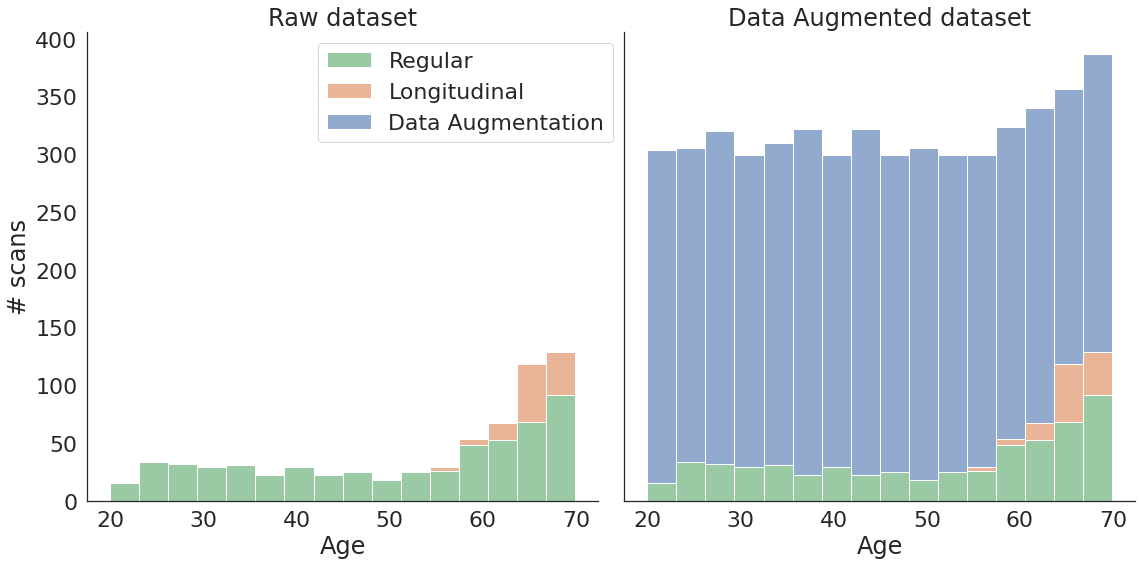

In [14]:
sns.set(context='notebook', style='white', 
        font='sans-serif', font_scale=2., 
        rc={'figure.figsize':(8,5)})

fig = plt.figure()
g = sns.FacetGrid(dt, col="Data", sharex=True,
                  height=5, size=8,
                  col_order=["Raw dataset", "Data Augmented dataset"],
                  palette=sns.color_palette('Set2')
                  )
g.map_dataframe(sns.histplot, x="Age", alpha=.6, hue='unique',
                hue_order=['Data Augmentation', 'Longitudinal','Regular'],
                multiple='stack', common_bins=True, bins=16,
                label='Data'
                ) 
g.set_xlabels("Age")
g.set_ylabels("# scans")
g.set_titles("{col_name}")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Regular', 'Longitudinal', 'Data Augmentation']
order = [0, 1, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0, 1))
plt.savefig('Data_augmentation_distribution_070.pdf', bbox_inches='tight', dpi=300)


In [15]:
dt_70 = train[train.split == '>70 years'].reset_index(drop=True)
dt_70['Data'] = 'Raw dataset'
dataAug = generate_dataAugmentation(dt_70, [70,100])
dataAug = pd.concat([dataAug, dt_70])
print(dataAug.shape)
dataAug['Data'] = 'Data Augmented dataset'
dt = pd.concat([dataAug, dt_70])

25.799999999999997
(1759, 9)


/home/kpoloni/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 576x360 with 0 Axes>

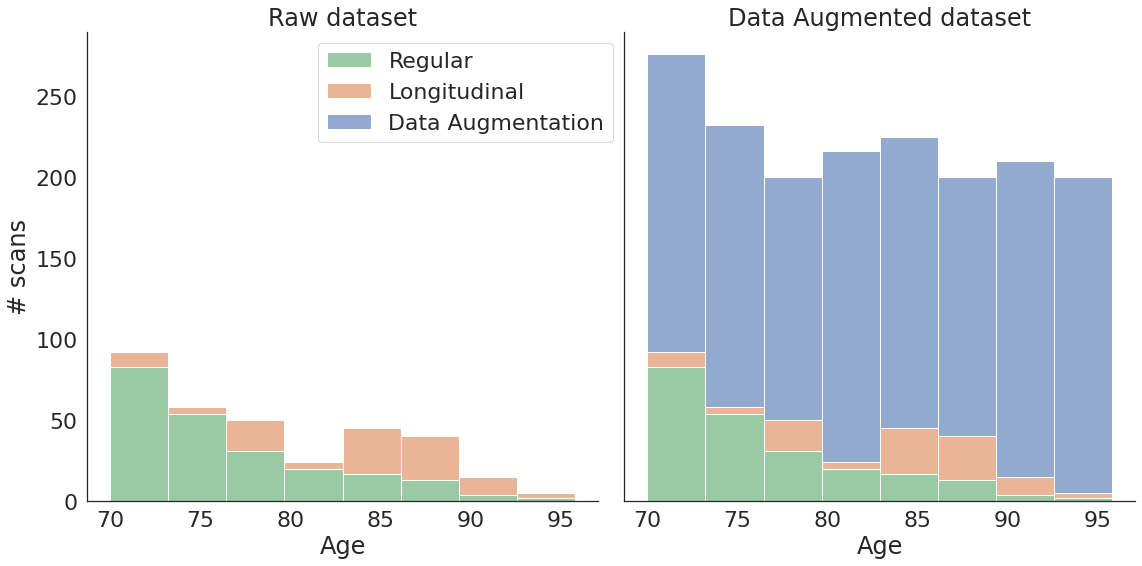

In [22]:
sns.set(context='notebook', style='white', 
        font='sans-serif', font_scale=2., 
        rc={'figure.figsize':(8,5)})

fig = plt.figure()
g = sns.FacetGrid(dt, col="Data", sharex=True,
                  height=5, size=8,
                  col_order=["Raw dataset", "Data Augmented dataset"],
                  palette=sns.color_palette('Set2')
                  )
g.map_dataframe(sns.histplot, x="Age", alpha=.6, hue='unique',
                hue_order=['Data Augmentation', 'Longitudinal','Regular'],
                multiple='stack', common_bins=True, bins=8,
                label='Data'
                ) 
g.set_xlabels("Age")
g.set_ylabels("# scans")
g.set_titles("{col_name}")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Regular', 'Longitudinal', 'Data Augmentation']
order = [0, 1, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0, 1))
plt.savefig('Data_augmentation_distribution_maior70.pdf', bbox_inches='tight', dpi=300)
